In [3]:
!pip install langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.8 MB/s eta 0:00:00


In [5]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


In [23]:

from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableLambda


In [41]:
pip install -U langchain-google-genai

In [24]:
from langchain.chat_models import init_chat_model
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
llm = init_chat_model("google_genai:gemini-2.0-flash-lite")

In [25]:
from typing import Annotated
from langgraph.graph.message import add_messages

class AgentState1(TypedDict):
    question: Annotated[str, add_messages]
    solution: Annotated[str, add_messages]
    result: str
    result_code: str
    feedback_msg: Annotated[str, add_messages]
    user_review: Annotated[str, add_messages]

In [26]:
def python_agent(state):
    prompt = f"""write a 'python program' for the user question {state["question"]}"""
    response = llm.invoke(prompt)
    state["result_code"] = response.content
    return state

In [27]:
def cpp_agent(state):
    prompt = f"""write a 'C++ program' for the user question {state["question"]}"""
    response = llm.invoke(prompt)
    state["result_code"] = response.content
    return state

In [28]:
def router(state):
    question = state["question"]
    prompt = f"""Determine the programming language that is asked in the {state["question"]} and {state['solution']}. Also, give the response in lower case."""
    response = llm.invoke(prompt)
    if "python" in response.content:
        return "python_agent"
    return "cpp_agent"

In [29]:
def feedback(state):
    prompt = f"""Give proper feedback by observing the difference between {state["solution"]}
    and {state["result_code"]}. Explain considering both time complexity and
    space complexity. And provide feedback to the user until he got to understand the
    optimized code well.
    """
    response = llm.invoke(prompt)
    state["feedback_msg"] = response.content
    return state

In [30]:
def explainer(state):
    prompt = f"""Since the user was not happy with the {state["feedback_msg"]} responce, provide a deeper and detaied
    explaination to the user regarding the user {state["solution"]} and the optimized solution.

    """
    response = llm.invoke(prompt)
    state['result'] = response.content
    return state

In [36]:
def router1(state):
    print(state["solution"][-1].content)
    print(state["result_code"])
    print(state["feedback_msg"][-1].content)
    user_review = input("\nEnter your review: ")
    user_review = user_review
    if any(phrase in user_review for phrase in ["yes","ok", "happy", "i am ok with it", "it is good"]):

        return "END"
    return "explainer"

In [37]:
graph = StateGraph(AgentState1)


#graph.set_entry_point("router_node")
graph.add_node("router", RunnableLambda(lambda x: x))
graph.add_node("python_agent", RunnableLambda(python_agent))
graph.add_node("cpp_agent", RunnableLambda(cpp_agent))
graph.add_node("feedback", RunnableLambda(feedback))
graph.add_node("router1", RunnableLambda(lambda x:x))
graph.add_node("explainer", RunnableLambda(explainer))

graph.add_edge(START, "router")
graph.add_conditional_edges("router",RunnableLambda(router),{
    "python_agent":"python_agent",
    "cpp_agent":"cpp_agent"
})
graph.add_edge("python_agent", "feedback")
graph.add_edge("cpp_agent", "feedback")
graph.add_edge("feedback", "router1")
graph.add_conditional_edges("router1",RunnableLambda(router1),{
    "END":END,
    "explainer":"explainer"
})
graph.add_edge("explainer",END)
graph.set_entry_point("router")


bot = graph.compile()


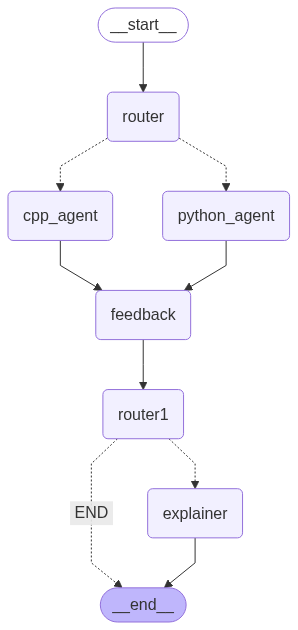

In [38]:
from IPython.display import Image, display
display(Image(bot.get_graph().draw_mermaid_png()))

In [39]:
question = "Write a function to check whether a given string is a palindrome (i.e., reads the same forward and backward). Ignore case and non-alphanumeric characters."
solution = """
import re

def is_palindrome(s):
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned = re.sub('[^a-zA-Z0-9]', '', s).upper

    # Compare cleaned string with its reverse
    return cleaned == cleaned[::-1

# Example usage
print(is_palindrome("A man, a plan, a canal: Panama"))
print(is_palindrome("race a car"))
"""

In [40]:
state = {"question": question, "solution": solution}
final_state = bot.invoke(state)

# Final Output
if "result" in final_state:
    print("\nFinal Explanation:\n")
    print(final_state["result"])
else:
    print("\nExecution complete. No further explanation required.")


import re

def is_palindrome(s):
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned = re.sub('[^a-zA-Z0-9]', '', s).upper
    
    # Compare cleaned string with its reverse
    return cleaned == cleaned[::-1

# Example usage
print(is_palindrome("A man, a plan, a canal: Panama")) 
print(is_palindrome("race a car"))  

```python
import re

def is_palindrome(text):
    """
    Checks if a given string is a palindrome, ignoring case and non-alphanumeric characters.

    Args:
        text: The string to check.

    Returns:
        True if the string is a palindrome, False otherwise.
    """

    # Remove non-alphanumeric characters and convert to lowercase
    processed_text = re.sub(r'[^a-zA-Z0-9]', '', text).lower()

    # Check if the processed string is equal to its reverse
    return processed_text == processed_text[::-1]


# Example Usage:
string1 = "Racecar"
string2 = "A man, a plan, a canal: Panama"
string3 = "hello"

print(f"'{string1}' is a palindrome